In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud

In [2]:
headlines_df = pd.read_csv('data/headlines_2018_2024.csv')
headlines_df.set_index('date', inplace=True)
df = headlines_df.copy()

In [3]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [4]:
def aggregate_dicts_to_mean(dict_list, verbose = False):
    sums = {key: 0.0 for key in dict_list[0].keys()}
    counts = {key: 0 for key in dict_list[0].keys()}
    
    for d in dict_list:
        for key in d.keys():
            sums[key] += d[key]
            counts[key] += 1
    
    means = {key: sums[key] / counts[key] for key in sums.keys()}
    if verbose:
        print(f"{means}")
    return means

In [5]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)    
       
    scores_dict = {
        'neg' : scores[0],
        'neu' : scores[1],
        'pos' : scores[2],
    }
    
    return scores_dict

In [6]:
text = df.loc['2018-01-19', 'headline']
text

'Olympic gymnast Aly Raisman confronts Larry Nassar in court'

In [7]:
polarity_scores_roberta(text)

{'neg': 0.15313382, 'neu': 0.82348144, 'pos': 0.023384677}

In [8]:
polarity_scores = []
max_iterations = df.shape[0]

def mean_roberta_score(row):
    
    for i in range(max_iterations):
        try:
            text = row.values[i]
            score = polarity_scores_roberta(text)
            polarity_scores.append(score)

        except RuntimeError:
            print(f'Error with: {text} on row: {row} for index: {i}.')

In [9]:
sentiment_df = df.apply(mean_roberta_score, axis=0)

In [10]:
neg_vals = [m['neg'] for m in polarity_scores]
neu_vals = [m['neu'] for m in polarity_scores]
pos_vals = [m['pos'] for m in polarity_scores]

In [11]:
df['negative'] = neg_vals
df['neutral']  = neu_vals
df['positive'] = pos_vals

In [12]:
df['sentiment'] = df[['negative', 'neutral', 'positive']].idxmax(axis=1)

In [13]:
df.index = pd.to_datetime(df.index)

In [14]:
df.to_csv('data/headlines_2018_2024_daily.csv', index=True)

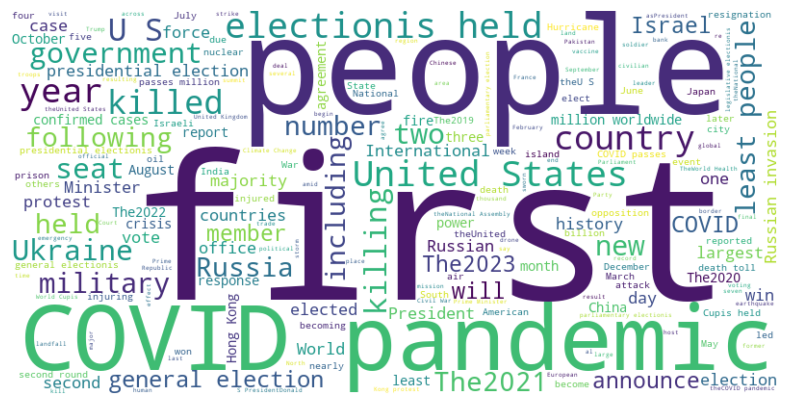

In [15]:
text = ' '.join(df['headline'].values.ravel())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Resample Global Events To Monthly Units

In [16]:
monthly_df = df.copy()
monthly_df = df.resample('M').mean(numeric_only=True)

In [17]:
col = 'negative'
prev = monthly_df.loc['2018-06-30', col] 
next = monthly_df.loc['2018-08-31', col] 
monthly_df.loc['2018-07-31', col] = (prev + next)/2

In [18]:
col = 'neutral'
prev = monthly_df.loc['2018-06-30', col] 
next = monthly_df.loc['2018-08-31', col] 
monthly_df.loc['2018-07-31', col] = (prev + next)/2

In [19]:
col = 'positive'
prev = monthly_df.loc['2018-06-30', col] 
next = monthly_df.loc['2018-08-31', col] 
monthly_df.loc['2018-07-31', col] = (prev + next)/2

In [20]:
col = 'negative'
prev = monthly_df.loc['2024-08-31', col] 
next = monthly_df.loc['2024-10-31', col] 
monthly_df.loc['2024-09-30', col] = (prev + next)/2

In [21]:
col = 'neutral'
prev = monthly_df.loc['2024-08-31', col] 
next = monthly_df.loc['2024-10-31', col] 
monthly_df.loc['2024-09-30', col] = (prev + next)/2

In [22]:
col = 'positive'
prev = monthly_df.loc['2024-08-31', col] 
next = monthly_df.loc['2024-10-31', col] 
monthly_df.loc['2024-09-30', col] = (prev + next)/2

In [23]:
monthly_df['sentiment'] = monthly_df[['negative', 'neutral', 'positive']].idxmax(axis=1)
monthly_df.to_csv('data/6_headlines_2018_2024.csv', index=True)